# Import libraries and set directories/filepaths

In [3]:
COLLAB = False

In [4]:
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [47]:
!pip install monai
!pip install seaborn
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import glob
import os
import sys
import gc
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import seaborn as sns
import monai
import numpy as np
import scipy.ndimage as ndi
from skimage import morphology
import pandas as pd
import scienceplots

# Include src directory in path to import custom modules
if os.path.join("..", "src") not in sys.path:
    sys.path.append(os.path.join("..", "src"))

In [6]:
os.getcwd()

'c:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\notebooks'

In [7]:
if COLLAB:
    os.chdir("/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/src/")
else:
    os.chdir("C:/Users/james/Documents/projects/pred-knee-replacement-oai/src")



In [8]:
cur_dir = os.getcwd()

print(f"The current working directory is: {cur_dir}")
print(f"The contents of this directory: {os.listdir()}")


The current working directory is: C:\Users\james\Documents\projects\pred-knee-replacement-oai\src
The contents of this directory: ['config', 'data', 'features', 'metrics', 'models', 'scripts', 'test.py', 'train.py', 'trainer', 'train_distributed.py', 'utils', 'visualization', 'wandb', '__init__.py', '__pycache__']


In [9]:
# Track reloads of custom modules - https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [10]:
import importlib

from models.model_unet import UNet3DMulticlass
import metrics.loss
importlib.reload(metrics.loss) # reload step 1
from metrics.loss import dice_coefficient_multi_batch, dice_coefficient_multi_batch_all

import data.datasets
importlib.reload(data.datasets)
from data.datasets import KneeSegDataset3DMulticlass

import utils.utils
importlib.reload(utils.utils)
from utils.utils import crop_im, crop_mask


In [11]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

Current device: cpu


In [12]:
# Define data directories

if COLLAB:
    DATA_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data"
    DATA_TEST_DIRECTORY = "/content/drive/MyDrive/Career/PhD/Project/Data/test"
    DATA_PROCESSED_DIRECTORY = "/content/drive/MyDrive/Projects/PhD/pred-knee-replacement-oai/data/processed"
    RESULTS_PATH = os.path.join('..', 'results')
    RESULTS_FIGURES_PATH = os.path.join('..', 'results', 'figures')
else:
    DATA_DIRECTORY = "C:/Users/james/OneDrive - University of Leeds/1. Projects/1.1 PhD/1.1.1 Project/Data/OAI Subset"
    DATA_TEST_DIRECTORY = "C:/Users/james/OneDrive - University of Leeds/1. Projects/1.1 PhD/1.1.1 Project/Data/OAI Subset/test"
    DATA_PROCESSED_DIRECTORY = os.path.join('..', 'data', 'processed')
    RESULTS_PATH = os.path.join('..', 'results')
    RESULTS_FIGURES_PATH = os.path.join('..', 'results', 'figures')




# Define test file paths
test_gt_mask_paths = [os.path.basename(x).split(".")[0] for x in glob.glob(os.path.join(DATA_TEST_DIRECTORY, "*"))]
print(f"Number of test images: {len(test_gt_mask_paths)}")
print(f"Test paths first examples: {test_gt_mask_paths[0:3]}")


Number of test images: 28
Test paths first examples: ['test_001_V00', 'test_001_V01', 'test_002_V00']


# Calculate evaluation metrics

In [18]:
# Define Dice Coefficient for two masks
def dice_coefficient(mask1, mask2):
    intersection = torch.sum(mask1 * mask2)
    sum = mask1.sum().item() + mask2.sum().item()
    dice = (2.0 * intersection) / sum
    return dice.item()

In [19]:
# Define a function that calculates the coefficient of variation of a mask
def coefficient_of_variation(mask):
    mean = torch.mean(mask)
    std = torch.std(mask)
    return std / mean



In [ ]:
# Define a function to calculate the thickness of a 3D segemnted region in an input mask

def calculate_thickness(mask):
    

In [ ]:
def calculate_eval_metrics(data_dir, data_processed_dir, test_paths, filename_prefix):

  tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"]
  num_classes = len(tissue_labels)


  all_dice_scores = []
  all_dice_scores_all_classes = []
  all_assd_all_classes = []
  all_voe_all_classes = []

  for filename in test_paths:
    print(f"\n{filename}")

    # Load ground truth mask
    print(f"\n Ground truth file: {filename}.npy")
    gt_mask = np.load(os.path.join(data_dir, "test_gt", filename + ".npy"))
    
    # Move classes dimension to be firt dimension
    gt_mask = np.transpose(gt_mask, (3,0,1,2))
    
    # Crop ground truth to match predicted
    gt_mask = crop_mask(gt_mask, dim1_lower=56, dim1_upper=312, dim2_lower=58, dim2_upper=314)

    # Load predicted binary mask
    print(f"\n Predicted mask file: {filename_prefix}{filename}.npy")
    pred_mask = np.load(os.path.join(data_processed_dir, filename_prefix + filename + ".npy"))
    
    # Remove first dim of 1 (batch)
    pred_mask = pred_mask.squeeze(axis=0)
    # Remove background
    pred_mask = pred_mask[1:,:,:,:]

    im_dice_scores = []


    #########################################################################
    # DICE SCORES
    #########################################################################
    # Dice dice for all classes together
    dice_score_all_classes = dice_coefficient(torch.tensor(gt_mask), torch.tensor(pred_mask))
    print(f"Dice score for all classes together: {dice_score_all_classes}")
    all_dice_scores_all_classes.append(dice_score_all_classes)

    for class_idx in range(num_classes):
      dice_score = dice_coefficient(torch.tensor(gt_mask[class_idx,...]), torch.tensor(pred_mask[class_idx,...]))
      print(f"Dice score for class {tissue_labels[class_idx]}: {dice_score}")
      im_dice_scores.append(dice_score)

    print(f"{filename} Average Dice score (class average): {np.mean(im_dice_scores)}")

    all_dice_scores.append(im_dice_scores)

    #########################################################################
    # ASSD
    #########################################################################

    # ASSD function expects batch dimension so add dim back
    pred_mask = np.expand_dims(pred_mask, axis=0)
    gt_mask = np.expand_dims(gt_mask, axis=0)

    # Compute ASSD - [0.36,0.36,0.7] is voxel resolution
    assd = monai.metrics.compute_average_surface_distance(pred_mask, gt_mask, symmetric=True, include_background=True, spacing=[0.36,0.36,0.7])
    print(f"ASSD score: {assd}")

    all_assd_all_classes.append(assd.tolist())

    #########################################################################
    # VOE
    #########################################################################
    # Compute VOE as (1 - IOU)
    IOU = monai.metrics.compute_iou(torch.tensor(pred_mask), torch.tensor(gt_mask), include_background=True)
    VOE = 1 - IOU
    print(f"VOE score: {VOE}")

    all_voe_all_classes.append(VOE.tolist())

  #############################################
  # REPORT RESULTS
  #############################################
  all_dice_scores = np.array(all_dice_scores)
  print(all_dice_scores.shape)
  print(f"Average Dice score (): {np.mean(all_dice_scores, axis=0)}")

  all_assd_all_classes = np.array(all_assd_all_classes)
  print(all_assd_all_classes.shape)
  print(f"Average ASSD score (): {np.mean(all_assd_all_classes, axis=0)}")

  all_voe_all_classes = np.array(all_voe_all_classes)
  print(all_voe_all_classes.shape)
  print(f"Average VOE score (): {np.mean(all_voe_all_classes, axis=0)}")


  #############################################
  # SAVE RESULTS
  #############################################
  # Save results to file
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "dice_scores_by_image_tissue.npy"), all_dice_scores)
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "assd_by_image_tissue.npy"), all_assd_all_classes.squeeze(axis=1))
  np.save(os.path.join(RESULTS_PATH, filename_prefix + "voe_by_image_tissue.npy"), all_voe_all_classes.squeeze(axis=1))


In [ ]:
# Calculate eval metrics for MANet
calculate_eval_metrics(data_dir=DATA_DIRECTORY, data_processed_dir=DATA_PROCESSED_DIRECTORY, test_paths=test_gt_mask_paths, filename_prefix="manet_")


test_001_V00

 Ground truth file: test_001_V00.npy

 Predicted mask file: manet_test_001_V00.npy
Dice score for all classes together: 0.8730980753898621
Dice score for class Femoral cart.: 0.9063949584960938
Dice score for class Tibial cart.: 0.8914586305618286
Dice score for class Patellar cart.: 0.0
Dice score for class Meniscus: 0.8973322510719299
test_001_V00 Average Dice score (class average): 0.6737964600324631
ASSD score: tensor([[ 0.2298,  0.2253, 46.6795,  0.3237]])
VOE score: tensor([[0.1712, 0.1958, 1.0000, 0.1862]])

test_001_V01

 Ground truth file: test_001_V01.npy

 Predicted mask file: manet_test_001_V01.npy
Dice score for all classes together: 0.841011643409729
Dice score for class Femoral cart.: 0.8931440114974976
Dice score for class Tibial cart.: 0.8133136630058289
Dice score for class Patellar cart.: 0.0
Dice score for class Meniscus: 0.8849503993988037
test_001_V01 Average Dice score (class average): 0.6478520184755325
ASSD score: tensor([[ 0.2359,  0.3474, 45.84

In [27]:
# Calculate eval metrics for U-Net
calculate_eval_metrics(data_dir=DATA_DIRECTORY, data_processed_dir=DATA_PROCESSED_DIRECTORY, test_paths=test_gt_mask_paths, filename_prefix="")


test_001_V00

 Ground truth file: test_001_V00.npy

 Predicted mask file: test_001_V00.npy


RuntimeError: The size of tensor a (256) must match the size of tensor b (264) at non-singleton dimension 2

## Visualise U-Net Results

In [22]:
# Load U-Net results
all_dice_scores = np.load(os.path.join(RESULTS_PATH, "dice_scores_by_image_tissue.npy"))
all_assd_all_classes = np.load(os.path.join(RESULTS_PATH, "assd_by_image_tissue.npy"))
all_voe_all_classes = np.load(os.path.join(RESULTS_PATH, "voe_by_image_tissue.npy"))

FileNotFoundError: [Errno 2] No such file or directory: '..\\results\\dice_scores_by_image_tissue.npy'

In [ ]:
# Print results summary
print(f"Average Dice scores by class: {np.mean(all_dice_scores, axis=0)}")
print(f"Dice Standard deviation by class: {np.std(all_dice_scores, axis=0)}\n")

print(f"Average ASSD by class: {np.mean(all_assd_all_classes, axis=0)}")
print(f"ASSD Standard deviation by class: {np.std(all_assd_all_classes, axis=0)}\n")

print(f"Average VOE by class: {np.mean(all_voe_all_classes, axis=0)}")
print(f"VOE Standard deviation by class: {np.std(all_voe_all_classes, axis=0)}")

Average Dice scores by class: [0.89038798 0.87044328 0.83737271 0.86775852]
Dice Standard deviation by class: [0.0196461  0.036194   0.08049821 0.02771924]

Average ASSD by class: [0.23659025 0.31035149 0.42748232 0.36537617]
ASSD Standard deviation by class: [0.02954349 0.18552363 0.60053689 0.08615763]

Average VOE by class: [0.19700768 0.22762739 0.27236088 0.23253895]
VOE Standard deviation by class: [0.03166155 0.0551583  0.10732154 0.04304123]


# Visualise evaluation metrics

In [ ]:
all_dice_scores.shape

(28, 4)

In [ ]:
def violin_plot(data, ylabel, title, filename, ref_high, ref_low, remove_patellar=False):
  tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"]
  rc1 = {'font.family' : 'DeJavu Serif', 'font.serif': 'Computer Modern'}
  with plt.rc_context(rc1):

    # creating a dictionary with one specific color per group:
    my_pal = {
        0: "g",
        1: "y",
        2: "b",
        3: "r",
    }

    xticks = [0,1,2,3]

    if remove_patellar:
      data = np.delete(data, 2, axis=1)
      tissue_labels = ["Femoral cart.", "Tibial cart.", "Meniscus"]
      xticks = [0,1,2]

      # creating a dictionary with one specific color per group:
      my_pal = {
          0: "g",
          1: "y",
          2: "r",
      }

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.grid(True, axis='y', color="0.7")
    ax.set_axisbelow(True)

    plt.ylabel(ylabel, fontsize=22)
    plt.xticks(xticks, tissue_labels, fontsize=22, rotation=25)
    plt.yticks(fontsize=22)
    plt.title(title, fontsize=24)

    ax = sns.violinplot(data=data, alpha=0.85, palette=my_pal)


    # set the position of the thresholds for each category

    # get the y-positions of the tick label for each category
    xpos = {c.get_text(): x for c, x in zip(ax.get_xticklabels(), ax.get_xticks())}

    # plot the threshold lines
    for tis in tissue_labels:
        ax.plot(
            [xpos[tis] - 0.2, xpos[tis] + 0.2],
            [ref_high[tis], ref_high[tis]],
            color="k",
            linestyle='dotted',
            lw=2,
        )

    # plot the threshold lines
    for tis in tissue_labels:
        ax.plot(
            [xpos[tis] - 0.2, xpos[tis] + 0.2],
            [ref_low[tis], ref_low[tis]],
            color="k",
            linestyle='dotted',
            lw=2,
        )

    plt.savefig(os.path.join(RESULTS_FIGURES_PATH, filename), bbox_inches="tight", dpi=500)
    plt.show()

In [ ]:
# Set high and low references from IWOAI
iwoai_dice_high = {
        "Femoral cart.": 0.90,
        "Tibial cart.": 0.89,
        "Patellar cart.": 0.86,
        "Meniscus": 0.88
      }

iwoai_dice_low = {
        "Femoral cart.": 0.87,
        "Tibial cart.": 0.85,
        "Patellar cart.": 0.83,
        "Meniscus": 0.83
      }



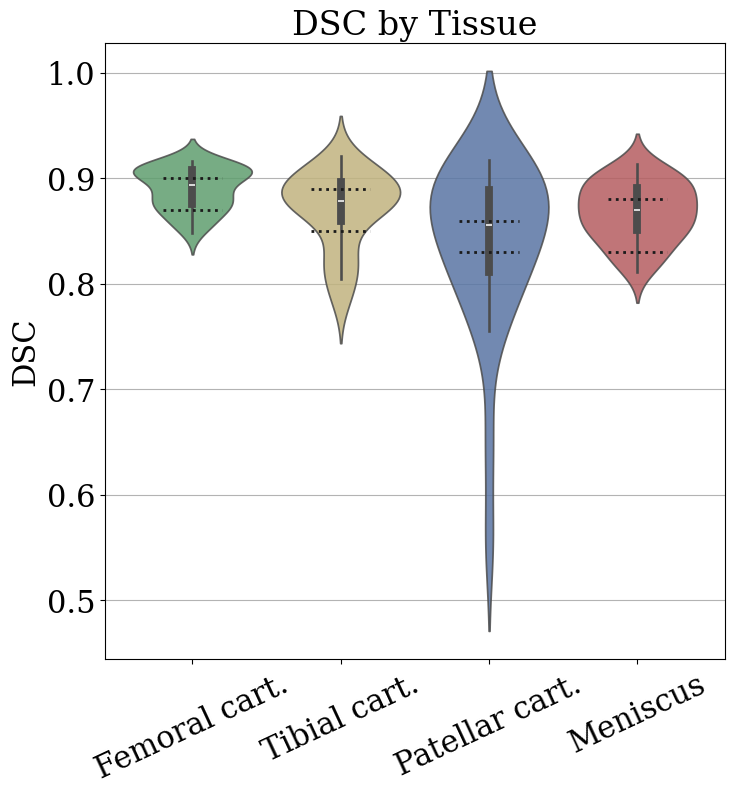

In [ ]:
violin_plot(
    data=all_dice_scores,
    ylabel="DSC",
    title="DSC by Tissue",
    filename="dice_by_tissue_violin",
    ref_high=iwoai_dice_high,
    ref_low=iwoai_dice_low,
  )

In [ ]:
iwoai_assd_high = {
        "Femoral cart.": 0.28,
        "Tibial cart.": 0.33,
        "Patellar cart.": 0.44,
        "Meniscus": 0.44
      }
iwoai_assd_low = {
        "Femoral cart.": 0.20,
        "Tibial cart.": 0.26,
        "Patellar cart.": 0.26,
        "Meniscus": 0.33
      }


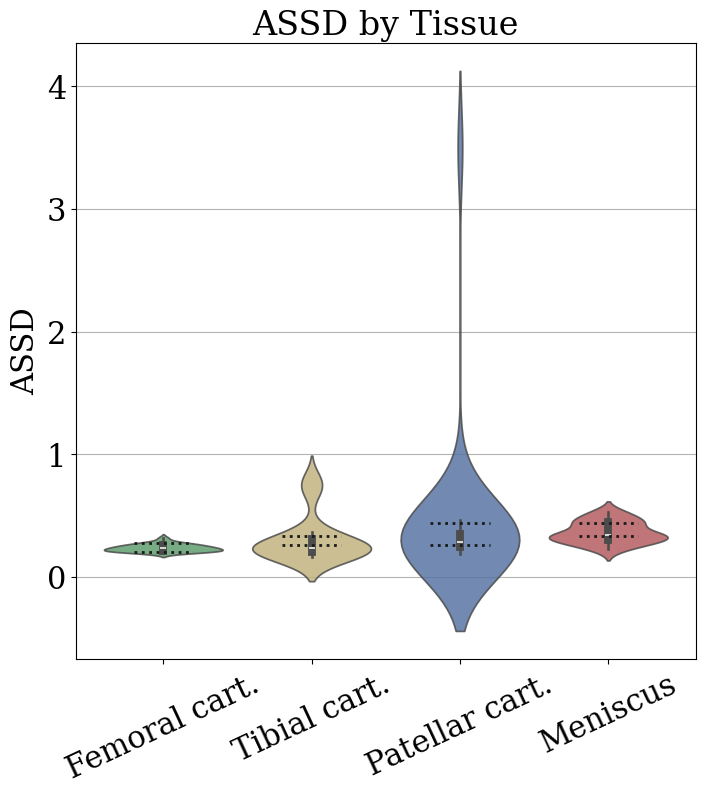

In [ ]:
violin_plot(
    data=all_assd_all_classes,
    ylabel="ASSD",
    title="ASSD by Tissue",
    filename="assd_by_tissue_violin",
    ref_high=iwoai_assd_high,
    ref_low = iwoai_assd_low
  )

In [ ]:
iwoai_voe_high = {
        "Femoral cart.": 0.22,
        "Tibial cart.": 0.26,
        "Patellar cart.": 0.29,
        "Meniscus": 0.28
      }
iwoai_voe_low = {
        "Femoral cart.": 0.17,
        "Tibial cart.": 0.20,
        "Patellar cart.": 0.24,
        "Meniscus": 0.22
      }

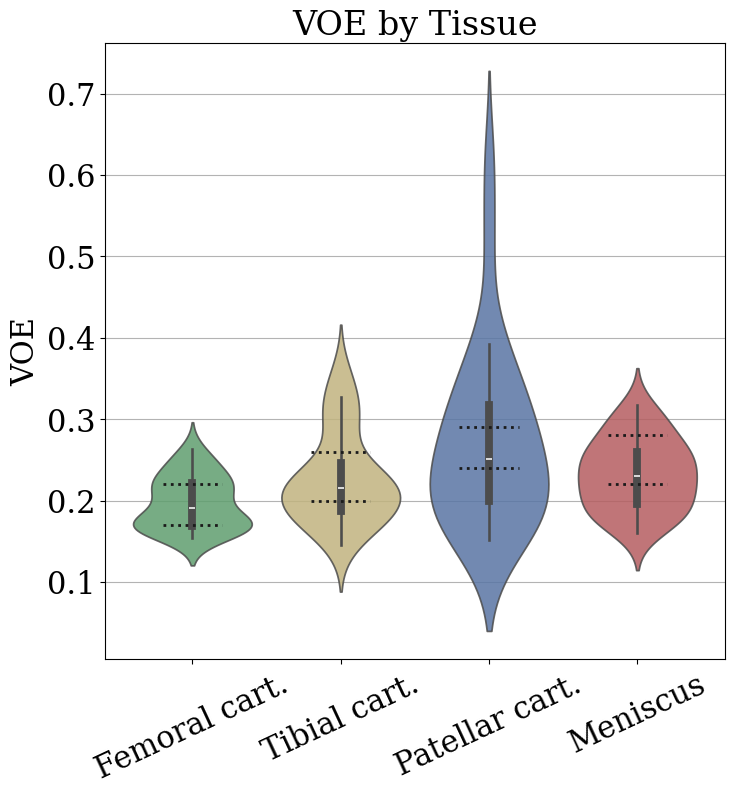

In [ ]:
violin_plot(
    data=all_voe_all_classes,
    ylabel="VOE",
    title="VOE by Tissue",
    filename="voe_by_tissue_violin",
    ref_high=iwoai_voe_high,
    ref_low=iwoai_voe_low
)

## Visualise MANet Results

In [ ]:
# Load U-Net results
manet_all_dice_scores = np.load(os.path.join(RESULTS_PATH, "manet_dice_scores_by_image_tissue.npy"))
manet_all_assd_all_classes = np.load(os.path.join(RESULTS_PATH, "manet_assd_by_image_tissue.npy"))
manet_all_voe_all_classes = np.load(os.path.join(RESULTS_PATH, "manet_voe_by_image_tissue.npy"))

In [ ]:
# Print results summary
print(f"Average Dice scores by class: {np.mean(manet_all_dice_scores, axis=0)}")
print(f"Dice Standard deviation by class: {np.std(manet_all_dice_scores, axis=0)}\n")

print(f"Average ASSD by class: {np.mean(manet_all_assd_all_classes, axis=0)}")
print(f"ASSD Standard deviation by class: {np.std(manet_all_assd_all_classes, axis=0)}\n")

print(f"Average VOE by class: {np.mean(manet_all_voe_all_classes, axis=0)}")
print(f"VOE Standard deviation by class: {np.std(manet_all_voe_all_classes, axis=0)}")

Average Dice scores by class: [0.87635585 0.73003403 0.         0.85625163]
Dice Standard deviation by class: [0.03845411 0.07528288 0.         0.02163576]

Average ASSD by class: [ 0.2794111   0.66760981 48.62165124  0.41128339]
ASSD Standard deviation by class: [0.13904482 0.31626337 4.45311673 0.0741098 ]

Average VOE by class: [0.21814239 0.41943175 1.         0.25073181]
VOE Standard deviation by class: [0.05664486 0.0968626  0.         0.03340438]


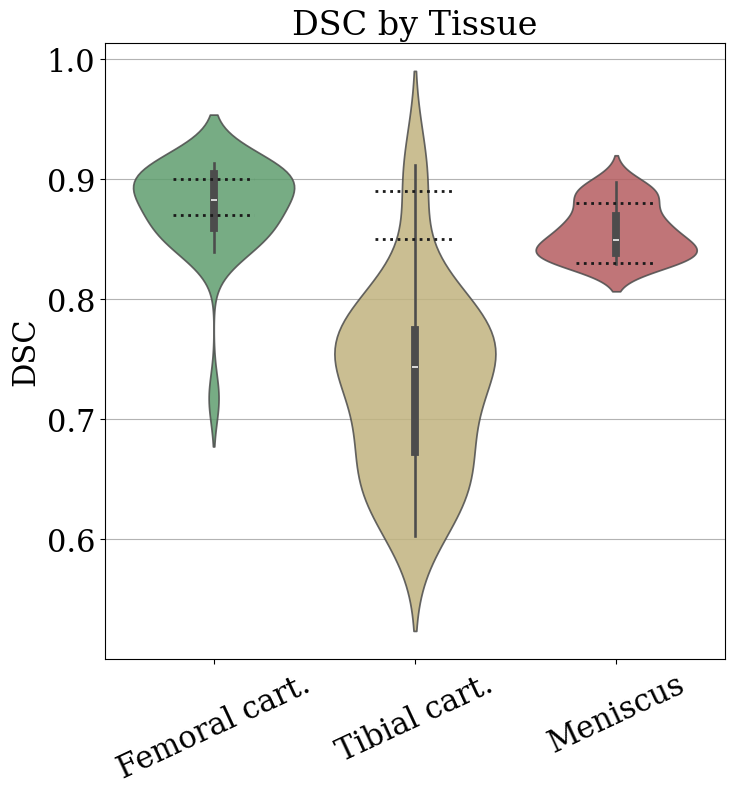

In [ ]:
violin_plot(
    data=manet_all_dice_scores,
    ylabel="DSC",
    title="DSC by Tissue",
    filename="manet_dice_by_tissue_violin",
    ref_high=iwoai_dice_high,
    ref_low=iwoai_dice_low,
    remove_patellar=True
  )

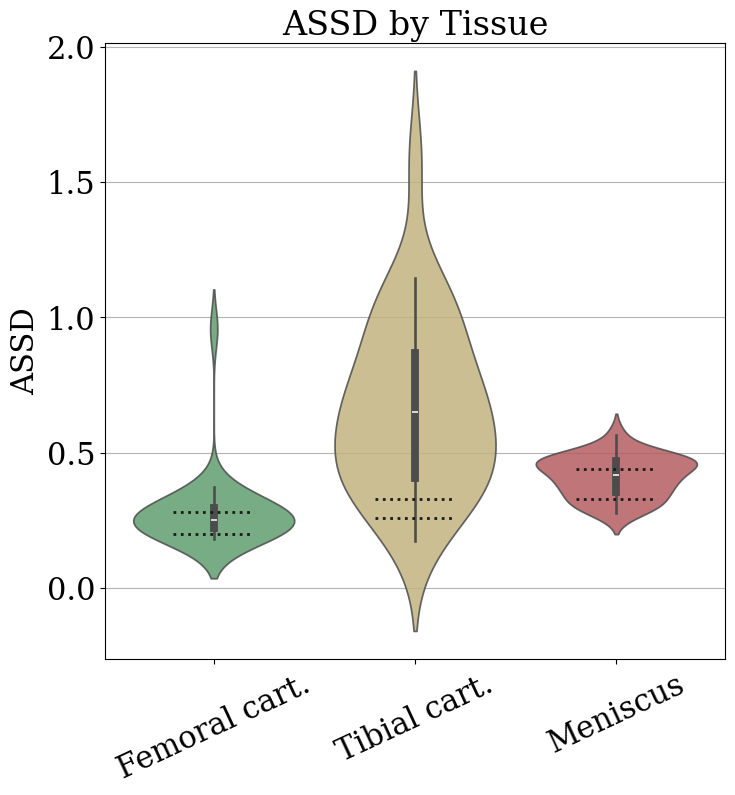

In [ ]:
violin_plot(
    data=manet_all_assd_all_classes,
    ylabel="ASSD",
    title="ASSD by Tissue",
    filename="manet_assd_by_tissue_violin",
    ref_high=iwoai_assd_high,
    ref_low = iwoai_assd_low,
    remove_patellar=True
  )

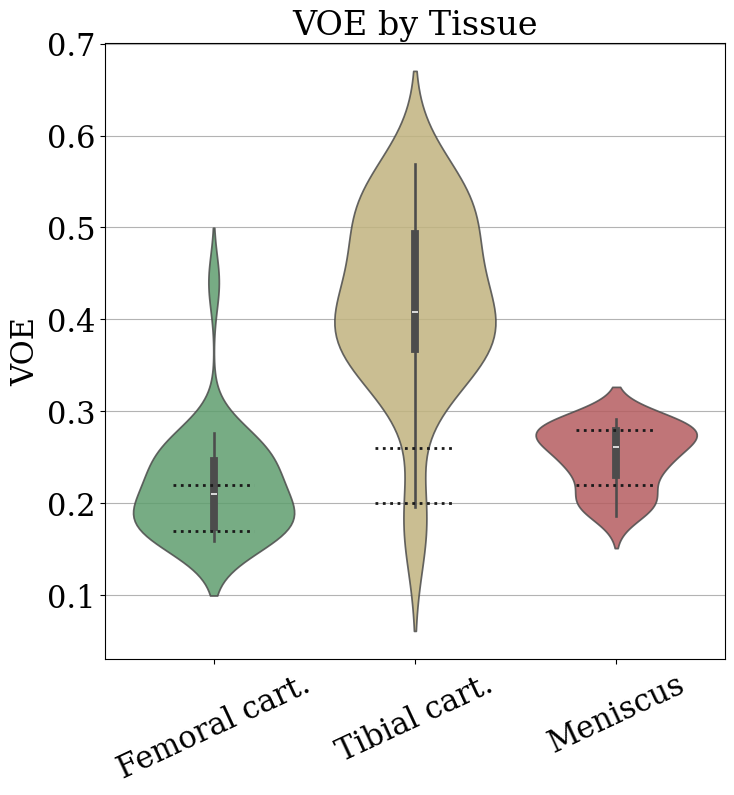

In [ ]:
violin_plot(
    data=manet_all_voe_all_classes,
    ylabel="VOE",
    title="VOE by Tissue",
    filename="manet_voe_by_tissue_violin",
    ref_high=iwoai_voe_high,
    ref_low=iwoai_voe_low,
    remove_patellar=True

)

# Segmentation Mask Visualisation

In [ ]:
# Load a predicted mask
pred_mask = np.load(os.path.join(DATA_PROCESSED_DIRECTORY, "test_001_V00.npy"))


In [ ]:
pred_mask = pred_mask.squeeze(axis=0)
pred_mask.shape

(5, 256, 264, 160)

In [69]:

# Visualise the predicted mask in 3D using a different colour for each class
def plot_3d_mask_multiclass(mask_all,
                            mask_colors, 
                            title,
                            results_dir,
                            filename,
                            tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"]) -> None:
    """_summary_

    Args:
        mask_all (np.array): the mask with all classes present
        mask_colors (np.array): the original one hot encoded mask, each class dimension is used to specify a colour
        title (str): title of the plot
        results_path (str): directory to write the plot to
        filename (str): name of output plot file 
        tissue_labels (list, optional): Defaults to ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"].
    """
    
    # Initialie figure
    fig = plt.figure(figsize=(10, 10))
    
    # Add subplot to figure
    ax = fig.add_subplot(111, projection='3d')


    # For each class in the predicted mask, visualise the mask in 3D using a different colour
    # for i in range(mask.shape[0]):
    #     ax.voxels(mask[i,:,:,:], edgecolor='k', facecolors=)

    # Build up the colors mask using the indvidual segmentation masks

    print("Setting up colors mask")
    print(f"Mask colors shape: {mask_colors.shape}")
    colors = np.empty(mask_all.shape, dtype=object)
    colors[mask_colors[0,:,:,:] == 1] = "red"
    colors[mask_colors[1,:,:,:] == 1] = "blue"
    colors[mask_colors[2,:,:,:] == 1] = "green"
    colors[mask_colors[3,:,:,:] == 1] = "yellow"

    print("Number of red voxels:", np.sum(colors == "red"))
    print("Number of blue voxels:", np.sum(colors == "blue"))
    print("Number of green voxels:", np.sum(colors == "green"))
    print("Number of yellow voxels:", np.sum(colors == "yellow"))

    ax.voxels(mask_all, edgecolor='k', facecolors=colors)

    ax.set_title(title)
    plt.legend(tissue_labels)
    plt.savefig(os.path.join(results_dir, filename), bbox_inches="tight", dpi=500)

    print(f"Saved figure to {os.path.join(results_dir, filename)}")




# Loop through all the paths to the predicted segmentation masks, load the masks and visualise them in 3D
def plot_all_3d_masks_multiclass(mask_paths, 
                                results_path,
                                tissue_labels = ["Femoral cart.", "Tibial cart.", "Patellar cart.", "Meniscus"],
                                remove_background=True) -> None:
    
    # Loop through all the predicted masks
    for i, mask_path in enumerate(mask_paths):
        
        print(f"Visualising mask {i+1}/{len(mask_paths)}")

        # Load mask using mask_path
        mask = np.load(mask_path)

        # Remove dimension of one from mask
        mask = np.squeeze(mask)
        
        # Remove background from mask
        if remove_background:
            print(f"Mask shape: {mask.shape}")
            print("Removing background mask")
            mask = mask[1:,:,:,:]
            print(f"Mask shape after removing background: {mask.shape}")

        # Convert mask so there are 1s if any class is present
        mask_all = np.any(mask, axis=0).astype(int)
        print(f"Mask all shape: {mask_all.shape}") 

        # Define the title for the plot
        title = f"{mask_path}: Predicted Segmentation Mask"
        
        # Define the filename for the plot
        filename = f"{os.path.splitext(os.path.basename(mask_path))[0]}_predicted_mask.png"
        
        # Visualise the predicted mask in 3D
        plot_3d_mask_multiclass(mask_all, mask, title, results_path, filename, tissue_labels)

In [ ]:
    # Create list of paths to the predicted masks from processed data folder
    figures_dir = "/mnt/scratch/scjb/results/figures"

    mask_paths = os.listdir(pred_masks_dir)
    print("Number of predicted masks:", len(mask_paths))
    print(f"Masks to be plotted: {mask_paths}")

    # Filter for numpy files
    mask_paths = [os.path.join(pred_masks_dir, mask_path) for mask_path in mask_paths if mask_path.endswith(".npy")]
    print("Number of predicted masks after filtering:", len(mask_paths))
    print("Mask paths after filtering:", mask_paths)

    # Visualise all the predicted masks in 3D
    plot_all_3d_masks_multiclass(mask_paths, figures_dir)

In [13]:
import plotly.graph_objects as go
import numpy as np

segmentation = np.random.randint(0, 2, (50, 50, 50))

x, y, z = np.where(segmentation > 1)
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
fig.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# Example segmentation data
segmentation = np.random.randint(0, 2, (50, 50, 50))

# Extract isosurface
verts, faces, _, _ = measure.marching_cubes(segmentation, level=0.5)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.7)
ax.add_collection3d(mesh)

plt.show()

ModuleNotFoundError: No module named 'skimage'

In [25]:
import os

os.getcwd()
os.listdir("C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\data\\processed\\pred_masks\\")


['manet_test_001_V00.npy',
 'manet_test_001_V01.npy',
 'manet_test_002_V00.npy',
 'manet_test_002_V01.npy',
 'manet_test_003_V00.npy',
 'manet_test_003_V01.npy',
 'manet_test_004_V00.npy',
 'manet_test_004_V01.npy',
 'manet_test_005_V00.npy',
 'manet_test_005_V01.npy',
 'manet_test_006_V00.npy',
 'manet_test_006_V01.npy',
 'manet_test_007_V00.npy',
 'manet_test_007_V01.npy',
 'manet_test_008_V00.npy',
 'manet_test_008_V01.npy',
 'manet_test_009_V00.npy',
 'manet_test_009_V01.npy',
 'manet_test_010_V00.npy',
 'manet_test_010_V01.npy',
 'manet_test_011_V00.npy',
 'manet_test_011_V01.npy',
 'manet_test_012_V00.npy',
 'manet_test_012_V01.npy',
 'manet_test_013_V00.npy',
 'manet_test_013_V01.npy',
 'manet_test_014_V00.npy',
 'manet_test_014_V01.npy',
 'test_001_V00.npy',
 'test_001_V01.npy',
 'test_002_V00.npy',
 'test_002_V01.npy',
 'test_003_V00.npy',
 'test_003_V01.npy',
 'test_004_V00.npy',
 'test_004_V01.npy',
 'test_005_V00.npy',
 'test_005_V01.npy',
 'test_006_V00.npy',
 'test_006_V0

# Thickness Error Caluclation

### Morphological Operations

In [ ]:
# Create a small array to test the functions
array = np.zeros((8, 8))
array[3:7, 3:7] = 1
#array[4:7, 5:7] = 1

print(array)

# Look at different morphologies
# Disk 
print("Disk 1 morphology")
print(morphology.disk(1))
# Ball
# print(morphology.ball(1))

# Square
print("Square 4 morphology")
print(morphology.square(4))

# Dilate
array_dilated = morphology.binary_dilation(array, morphology.square(3)).astype(np.uint8)

print("Dilated array using square 2")
print(array_dilated)

In [ ]:
print("Our starting array")
array = array.astype(bool).astype(np.uint8)
print(array)

print("\n\nThe eroded array")
eroded = morphology.binary_erosion(array).astype(np.uint8)
print(eroded)

In [ ]:
print("Our starting array")
array = array.astype(bool).astype(np.uint8)
print(array)

print("\n\nThe eroded array")
eroded = morphology.binary_erosion(array).astype(np.uint8)
print(eroded)

In [ ]:
print("\n\nNow we can calculate the boundary")
print("The boundary is the difference between the original array and the eroded array")
print("Boundary array")
boundary = array & ~eroded
print(boundary)

# Distance transform replaces each foreground pixel with the distance to the nearest background pixel
print("\n\nDistance transfrom")
dist_transform  = ndi.distance_transform_edt(array).astype(np.uint8)
print(dist_transform)

In [ ]:
print("\n\nNow we can calculate the boundary")
print("The boundary is the difference between the original array and the eroded array")
print("Boundary array")
boundary = array & ~eroded
print(boundary)

# Distance transform replaces each foreground pixel with the distance to the nearest background pixel
print("\n\nDistance transfrom")
dist_transform  = ndi.distance_transform_edt(array).astype(np.uint8)
print(dist_transform)

### Thick Error Calculation

In [6]:
# Set predicted mask directory
pred_masks_dir = "C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\data\\processed\\pred_masks\\"

# Load segmentation mask
segmentation = np.load(os.path.join(pred_masks_dir, "test_001_V00.npy"))

segmentation = segmentation.squeeze()

print(f"Segmentation shape: {segmentation.shape}")
print(f"Segementation values: {np.unique(segmentation)}")


# # Convert segmentation from one hot encoding to single channel 
# segmentation_single = np.argmax(segmentation, axis=0)

# Convert segmentation mask from one hot encoding to single channel with classes as different values
segmentation_single = np.argmax(segmentation, axis=0)

segmentation_single.shape


Segmentation shape: (5, 256, 264, 160)
Segementation values: [0 1]


(256, 264, 160)

In [7]:
test = morphology.skeletonize(segmentation[1,:,:,:], method="lee")
np.unique(test)

array([False,  True])

Segmmentation shape: (5, 256, 264, 160)
Segmentation skeletonised shape: (5, 256, 264, 160)
Segmentation skeletonised values: [0. 1.]
Segmentation skeletonised one channel shape: (256, 264, 160)
Segmentation skeletonised one channel values: [0 1]


KeyboardInterrupt: 

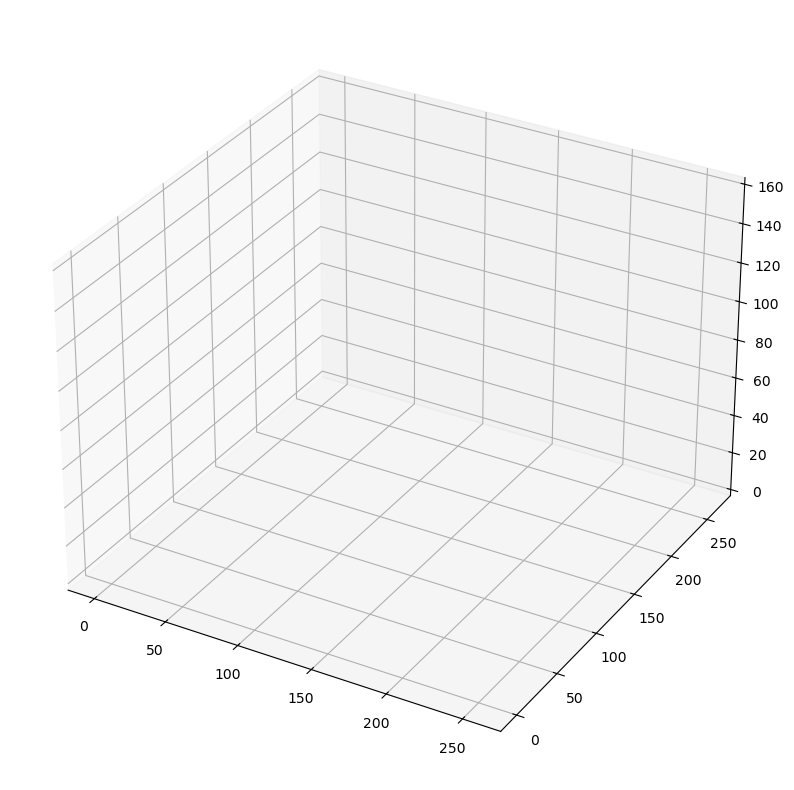

In [99]:
slice = 70 
print(f"Segmmentation shape: {segmentation.shape}")

# Skeletonise each class separately
segmentation_skel = np.zeros(segmentation.shape)

for i in range(segmentation_skel.shape[0]):
    segmentation_skel[i,:,:,:] = morphology.skeletonize(segmentation[i,:,:,:], method="lee")

print(f"Segmentation skeletonised shape: {segmentation_skel.shape}")
print(f"Segmentation skeletonised values: {np.unique(segmentation_skel)}")

# Transform skeletonised mask as one channel mask
segmentation_skel_one_channel = np.any(segmentation_skel, axis=0).astype(int)

print(f"Segmentation skeletonised one channel shape: {segmentation_skel_one_channel.shape}")
print(f"Segmentation skeletonised one channel values: {np.unique(segmentation_skel_one_channel)}")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(segmentation_skel_one_channel, edgecolor='k', facecolors="red")

plt.savefig("C:/Users/james/Downloads", bbox_inches="tight", dpi=500)


In [35]:
import skimage as ski
horse = ski.data.horse()

horse.shape
horse

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Input sgementation mask is 4D - looping thorugh onehot encoded masks...
Segmentation skeleton shape: (4, 100, 100, 100)
Segmentation skeleton values: [0 1]
Thickness shape: (4, 100, 100, 100)
Thickness values: [ 0 30 50]
Mean thickness: [50.0, 30.0, 30.0, 50.0]


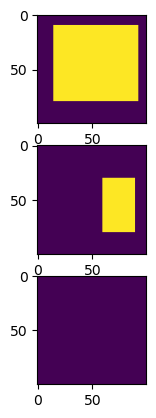

In [49]:
# Thickness calculation

test = np.zeros((4, 100, 100, 100)).astype(np.uint8)
test[0, 10:80, 15:93, 10:60] = 1
test[1, 30:80, 60:90, 10:60] = 1
test[2, 30:80, 60:90, 10:60] = 1
test[3, 10:80, 10:90, 10:60] = 1

# Create two matplotlib sbplots
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.imshow(test[0,:,:,30])
ax2.imshow(test[1,:,:,30])



def calculate_thickness(segmentation):
            
    # If a 2 or 3 dimensional array calculate the distance transform and skeletonise using the standard methods
    if len(segmentation.shape) in (2,3):

        distance_transform = ndi.distance_transform_edt(segmentation)
        segmentation_skeleton = morphology.skeletonize(segmentation, method="lee")
        
    # If a 4-dimensional array is passed, loop through the first dimension (e.g. class for onehot encoded mask)
    if len(segmentation.shape) == 4:

        print("Input sgementation mask is 4D - looping thorugh onehot encoded masks...")
        
        # Calculate the distance transform of the mask
        distance_transform = np.zeros(segmentation.shape).astype(np.uint8)
        for i in range(segmentation.shape[0]):
            distance_transform[i,...] = ndi.distance_transform_edt(segmentation[i,...]).astype(np.uint8)
            # print(f"Unique values in distance transform: {np.unique(distance_transform)}")
        

        # Calculate the skeletonised distance transform
        segmentation_skeleton = np.zeros(segmentation.shape, dtype=np.uint8)
        
        for i in range(segmentation.shape[0]):    
            current_volume = segmentation[i,...]
            # print(f"Current volume shape: {current_volume.shape}")
            # print(f"Current volume unqiue values: {np.unique(current_volume)}")

            segmentation_skeleton[i,...] = morphology.skeletonize(current_volume).astype(np.uint8)
        
        
        ax3.imshow(segmentation_skeleton[0,:,:,50])
            
        print(f"Segmentation skeleton shape: {segmentation_skeleton.shape}")
        print(f"Segmentation skeleton values: {np.unique(segmentation_skeleton)}")

    # Determine thickness as the distance transform of the skeletonised mask multiplied by 2
    thickness = distance_transform * segmentation_skeleton * 2
    print(f"Thickness shape: {thickness.shape}")
    #print(f"Thickness\n: {thickness.astype(np.uint8)}")

    # Extract non-zero values
    print(f"Thickness values: {np.unique(thickness)}")
    
    shape_thickness_values = []

    for i in range (segmentation.shape[0]): 
        non_zero_thickness = list(thickness[i, ...][thickness[i, ...] != 0])
        # print(non_zero_thickness)
        shape_thickness_values.append(non_zero_thickness)

    # print(shape_thickness_values)
    mean_thickness = [np.mean(x) for x in shape_thickness_values]

    return mean_thickness


mean_thickness = calculate_thickness(test)
print(f"Mean thickness: {mean_thickness}")

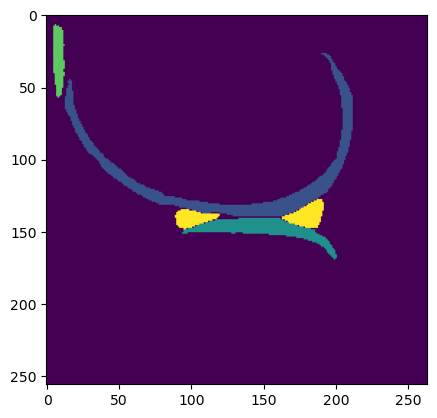

In [27]:
plt.imshow(segmentation_single[:,:,50], cmap="viridis")

In [28]:
segmentation_single[20:40,0:20,100]

array([[0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
       [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
       [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0],
       [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0],
       [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 3, 3,

In [29]:
segmentation_single[40:60,40:60,80]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import numpy as np
import plotly.graph_objects as go

res_fig_path = "C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\results\\figures\\"


# Define a discrete color scale for 5 classes
discrete_colorscale = [
    [0.00, "rgba(0, 0, 0, 0)"],  # Background (Transparent)
    [0.20, "blue"],              # Class 1
    [0.40, "red"],               # Class 2
    [0.60, "green"],             # Class 3
    [0.80, "yellow"],            # Class 4
    [1.00, "purple"],            # Class 5 (optional extra)
]



# # Generate a synthetic 3D segmentation mask (Replace with your actual data)
# segmentation = np.zeros((50, 50, 50))
# segmentation[10:40, 10:40, 10:40] = 1  # Example: A cube in the center

# Create 3D coordinate grid
x, y, z = np.mgrid[:segmentation_single.shape[0], :segmentation_single.shape[1], :segmentation_single.shape[2]]

# Convert segmentation data to 1s and 0s (binary mask)
volume_data = segmentation_single.astype(np.uint8)

# Create a volume rendering
fig = go.Figure(data=go.Volume(
    x=x.flatten(),  # X coordinates
    y=y.flatten(),  # Y coordinates
    z=z.flatten(),  # Z coordinates
    value=volume_data.flatten(),  # Flattened segmentation mask values
    isomin=0.5,  # Threshold to visualize the segmented region
    isomax=4,  # Max value for the mask
    opacity=1,  # Adjust opacity for better visibility
    surface_count=5,  # Number of contour surfaces
    colorscale=discrete_colorscale  # Color mapping
))

# Show the figure
fig.write_image("C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\results\\figures\\segmentation.png")
# fig.write_html('C:\\Users\\james\\Documents\\projects\\pred-knee-replacement-oai\\results\\figures\\segmentation.html')


In [15]:
import numpy as np
import plotly.graph_objects as go

# Create a sample 3D segmentation map (for example purposes)
nx, ny, nz = 100, 100, 100
seg = np.random.randint(0, 5, size=(nx, ny, nz))  # 5 classes: 0, 1, 2, 3, 4

# Define colors for each of the 5 classes
class_colors = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'yellow',
    4: 'purple'
}

# Initialize the figure
fig = go.Figure()

# Loop over each class, extract voxel coordinates, and add a trace
for cls in range(5):
    # Get the indices where the segmentation map equals the current class
    x, y, z = np.where(seg == cls)
    
    # Add a 3D scatter trace for this class
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=3,
            color=class_colors[cls],
            opacity=0.8
        ),
        name=f'Class {cls}'
    ))

# Update the layout with axis titles and a figure title
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Segmentation Map'
)

fig.show()

256

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Create a sample 3D segmentation map (values: 0=background, 1-4 are classes)
nx, ny, nz = 20, 20, 20
seg = np.random.randint(0, 5, size=(nx, ny, nz))

# Create grid coordinates for the volume
x = np.linspace(0, nx - 1, nx)
y = np.linspace(0, ny - 1, ny)
z = np.linspace(0, nz - 1, nz)
X, Y, Z = np.mgrid[:segmentation_single.shape[0], :segmentation_single.shape[1], :segmentation_single.shape[2]]

# With isomin=-0.5 and isomax=4.5, the boundaries for discrete classes are:
# -0.5 to 0.5: class 0 (background)
# 0.5 to 1.5: class 1
# 1.5 to 2.5: class 2
# 2.5 to 3.5: class 3
# 3.5 to 4.5: class 4

# Define a discrete colorscale. (Class 0 is assigned 'red' here, but we will hide it via opacity.)
colorscale = [
    [0.0, 'purple'],
    [0.2, 'purple'],
    [0.2, 'green'],
    [0.4, 'green'],
    [0.4, 'blue'],
    [0.6, 'blue'],
    [0.6, 'yellow'],
    [0.8, 'yellow'],
    [0.8, 'red'],
    [1.0, 'red']
]

# Define an opacityscale to hide the background.
# Normalized values for each class boundary (based on isomin and isomax) are:
# 0: ~0.1, 1: ~0.3, 2: ~0.5, 3: ~0.7, 4: ~0.9.
# Here we set the opacity for the background region ([0.0, 0.2]) to 0.
opacityscale = [
    [0.0, 0.0],
    [0.2, 0.0],1
    [0.2, 0.8],
    [0.4, 0.8],
    [0.4, 0.8],
    [0.6, 0.8],
    [0.6, 0.8],
    [0.8, 0.8],
    [0.8, 0.8],
    [1.0, 0.8]
]

# Create the volume trace, note the inclusion of the opacityscale
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=segmentation_single.flatten(),
    isomin=-0.5,
    isomax=4.5,
    surface_count=5,  # one surface per class interval
    colorscale="Phase",
    opacityscale=opacityscale,
    colorbar=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4],
        ticktext=['Background', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
    )
))

fig.update_layout(title='3D Segmentation Map using Volume (Background Hidden)')
fig.write_image("C:\\Users\\james\\Downloads\\plotly_test.png")
#fig.show()

In [ ]:
# load segmentation mask
segmentation = np.load(os.path.join(DATA_PROCESSED_DIRECTORY, "test_001_V00.npy"))

# Bland-Altman plots

In [16]:
os.getcwd()
os.listdir("../results/eval_metrics/nnunet/2025-04-01_11-39-52")

['assd_nnunet_2025-04-01_11-39-52.csv',
 'dice_nnunet_2025-04-01_11-39-52.csv',
 'hd_nnunet_2025-04-01_11-39-52.csv',
 'te_nnunet_2025-04-01_11-39-52.csv',
 'tm_nnunet_2025-04-01_11-39-52.csv',
 'voe_nnunet_2025-04-01_11-39-52.csv']

In [28]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
# plt.rcParams['text.usetex'] = True # TeX rendering

   Unnamed: 0  fem cart.  tibial cart.  patellar cart.  meniscus  \
0           0   0.133790      0.168125        0.247120  0.123102   
1           1   0.154188      0.168604        0.228362  0.144388   
2           2   0.137937      0.178703        0.121752  0.186680   
3           3   0.155103      0.176114        0.130113  0.228134   
4           4   0.141959      0.140940        0.180755  0.216920   

                img  
0  test_001_V00.npy  
1  test_001_V01.npy  
2  test_002_V00.npy  
3  test_002_V01.npy  
4  test_003_V00.npy  


C:\Users\james\AppData\Local\Temp\ipykernel_36440\3280023294.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].axhline(te_means[0], xmin=0, xmax=1, color="grey", linestyle="dotted", lw=1.8, zorder=1)
C:\Users\james\AppData\Local\Temp\ipykernel_36440\3280023294.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].axhline(te_means[0] + te_std[0], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)
C:\Users\james\AppData\Local\Temp\ipykernel_36440\3280023294.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

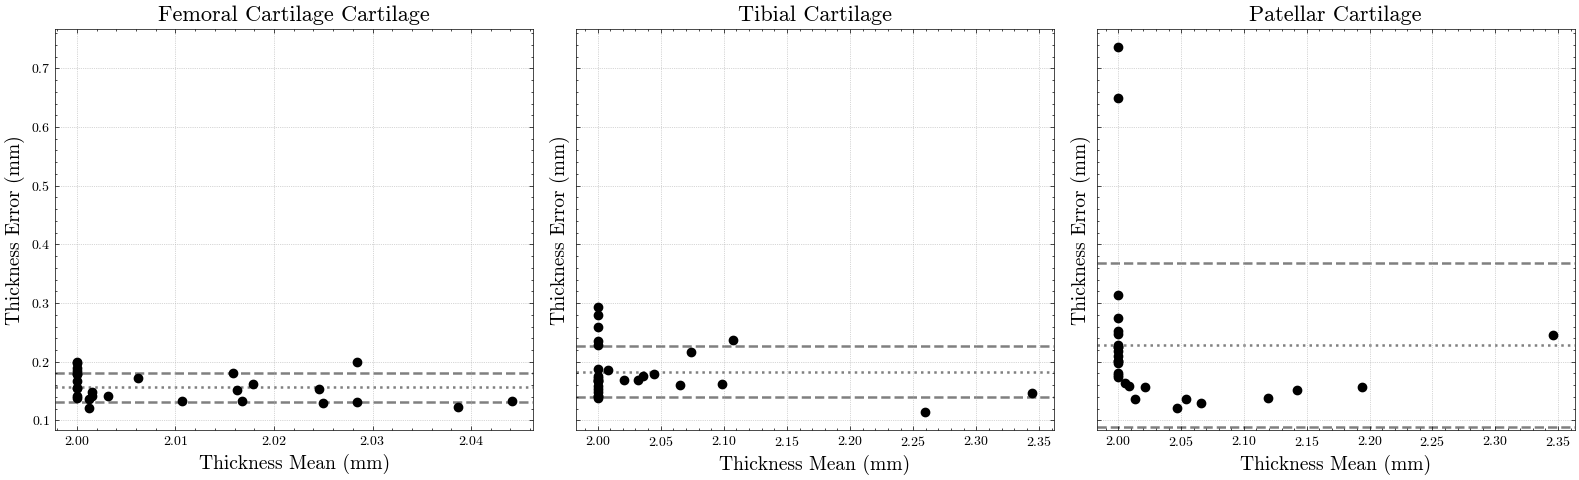

In [91]:
# Thickness different by thickness mean
# Save thickness mean separetly
# import scienceplots

# plt.rcParams['text.usetex'] = True # TeX rendering
# plt.style.use('science')

model = "nnunet"
run_start_time = "2025-04-01_11-39-52"
eval_metrics_dir = os.path.join(RESULTS_PATH, "eval_metrics", model, run_start_time)

df_te = pd.read_csv(os.path.join(eval_metrics_dir, f"te_{model}_{run_start_time}.csv"))
df_tm = pd.read_csv(os.path.join(eval_metrics_dir, f"tm_{model}_{run_start_time}.csv"))

print(df_te.head())

# Calculate mean thickness and thick error for each cartilage type
te_means = df_te[["fem cart.", "tibial cart.", "patellar cart."]].mean()
tm_means = df_tm[["fem cart.", "tibial cart.", "patellar cart."]].mean()
te_std = df_te[["fem cart.", "tibial cart.", "patellar cart."]].std()
tm_std = df_tm[["fem cart.", "tibial cart.", "patellar cart."]].std()


# plt.rcParams['text.usetex'] = True # TeX rendering

with plt.style.context(['science', 'no-latex']):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)

    axs[0].scatter(df_tm["fem cart."], df_te["fem cart."], color="black", zorder=2)
    axs[0].grid(linestyle='dotted')
    # axs[0].set_xlabel(r"$\mathrm{Thickness \ Mean}$", fontsize=16) 
    axs[0].set_xlabel("Thickness Mean (mm)", fontsize=14) 
    axs[0].set_ylabel("Thickness Error (mm)", fontsize=14) 
    axs[0].set_title("Femoral Cartilage Cartilage", fontsize=16)
    axs[0].axhline(te_means[0], xmin=0, xmax=1, color="grey", linestyle="dotted", lw=1.8, zorder=1)
    axs[0].axhline(te_means[0] + te_std[0], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)
    axs[0].axhline(te_means[0] - te_std[0], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)

    axs[1].scatter(df_tm["tibial cart."], df_te["tibial cart."], color="black", zorder=2)
    axs[1].grid(linestyle='dotted')
    axs[1].set_xlabel("Thickness Mean (mm)", fontsize=14) 
    axs[1].set_ylabel("Thickness Error (mm)", fontsize=14)
    axs[1].set_title("Tibial Cartilage", fontsize=16)
    axs[1].axhline(te_means[1], xmin=0, xmax=1, color="grey", linestyle="dotted", lw=1.8, zorder=1)
    axs[1].axhline(te_means[1] + te_std[1], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)
    axs[1].axhline(te_means[1] - te_std[1], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)

    # axs[1].set_xlabel(r"$\mathrm{Thickness \  Mean$}", fontsize=16) 

    axs[2].scatter(df_tm["patellar cart."], df_te["patellar cart."], color="black", zorder=2)
    axs[2].grid(linestyle='dotted')
    axs[2].set_xlabel("Thickness Mean (mm)", fontsize=14) 
    axs[2].set_ylabel("Thickness Error (mm)", fontsize=14) 
    axs[2].set_title("Patellar Cartilage", fontsize=16)
    axs[2].axhline(te_means[2], xmin=0, xmax=1, color="grey", linestyle="dotted", lw=1.8, zorder=1)
    axs[2].axhline(te_means[2] + te_std[2], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)
    axs[2].axhline(te_means[2] - te_std[2], xmin=0, xmax=1, color="grey", linestyle="--", lw=1.8, zorder=1)
    # axs[2].set_xlabel(r"$\mathrm{Thickness \: Mean}$}", fontsize=16) 

    plt.tight_layout()
    plt.show()